In [1]:
import operator
import random
import requests
import time
import csv
import os
import pandas as pd
import seaborn as sns
import numpy as np
import networkx as nx
from scipy import stats
from ast import literal_eval
from matplotlib import pyplot as plt
from statsmodels.stats import diagnostic
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split

# Data standard scaler
from sklearn.preprocessing import StandardScaler

# Random train-test split
from sklearn.model_selection import train_test_split

# Metrics and model selection
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, auc, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_val_predict

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from scipy.stats import ttest_ind

#To visualize on of the RandomForest decision trees
#from sklearn import tree

#colors used when comparing genders
PURPLE = 'purple'
ORANGE = '#ffb82c'

#colors used when generic comparisons
BLUE = '#0173b2'
RED = '#d55e00'

#print(sns.color_palette("colorblind").as_hex())
#sns.color_palette("colorblind")

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# 1. Load the data
<a class="anchor" id="load"></a>

In [3]:
DATA_PATH = './data'
MOVIE_PATH = os.path.join(DATA_PATH, 'american_movies_cleaned.tsv')
CHAR_PATH = os.path.join(DATA_PATH, 'characters_cleaned.tsv')
THE_NUMBERS_PATH = os.path.join(DATA_PATH, 'the_numbers_cleaned_yearly_decayed.tsv')

### 1.1 Characters data
<a class="anchor" id="load_characters"></a>

In [4]:
df_chars=pd.read_csv(CHAR_PATH, sep="\t")
df_chars['m_release_date']=pd.to_datetime(df_chars['m_release_date'], errors = 'coerce')
df_chars.head(2)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_character_map,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4


### 1.2 Movies data
<a class="anchor" id="load_movies"></a>

In [5]:
df_movies=pd.read_csv(MOVIE_PATH, sep='\t')
df_movies['m_release_date']=pd.to_datetime(df_movies['m_release_date'], errors = 'coerce')
df_movies.head(2)

,wikipedia_m_ID,freebase_m_ID,m_name,m_release_date,m_BO_revenue,m_runtime,m_languages,m_countries,m_genres,m_genre_PCA
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,['English Language'],United States of America,"['Thriller', 'Science Fiction', 'Horror', 'Adv...","Thriller, Crime Thriller, Action, Mystery"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,['English Language'],United States of America,"['Mystery', 'Biographical film', 'Drama', 'Cri...","Mystery, Horror, Children's/Family, Drama"


### 1.3 The numbers data

In [6]:
df_numbers=pd.read_csv(THE_NUMBERS_PATH, sep='\t').set_index('actor_name')
df_numbers.head(2)

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
actor_name,,,,,,,,,,,,,,,,,,,,,
Jane Fonda,328.691575,626.104012,566.522337,512.610609,463.829260,419.690070,588.918645,532.875627,482.165806,436.281663,...,155.940906,194.223037,175.740272,159.016374,143.883965,326.078494,295.048022,266.970491,241.564890,218.576951
Clint Eastwood,577.700345,522.724888,758.511094,998.420210,1457.867491,1591.382644,1715.512267,1552.259691,1643.591069,1580.145973,...,763.566226,690.903293,625.155152,565.663773,511.833748,698.854629,632.349818,572.173776,637.248452,576.606244


# 2.1 Df chars cleaning

In [7]:
# Keeps just one row if an actor played several roles in a movie
df_chars.drop_duplicates(['wikipedia_m_ID', 'actor_name'], keep='first', inplace=True)

In [8]:
# Keeps only movies where we have at least two actors (as the interest is coacting)
df_chars = df_chars[df_chars.duplicated('wikipedia_m_ID', keep=False)]

In [9]:
# Keeps only characters from american movies
df_chars = df_chars.merge(df_movies[['wikipedia_m_ID']], how='inner', on='wikipedia_m_ID')

# 2.2 Df movies cleaning

In [10]:
# Keeps only movies where actors data is available
df_movies = df_movies.merge(df_chars.drop_duplicates('wikipedia_m_ID', keep='first'), how='inner', on='wikipedia_m_ID')

# 2.3 Compute number of actors per movie

In [11]:
#compute number of actors per movie
nb_actors_per_movie = df_chars['wikipedia_m_ID'].value_counts().reset_index().copy()
nb_actors_per_movie.rename({'wikipedia_m_ID': 'nb_actors', 'index': 'wikipedia_m_ID'}, axis=1, inplace=True)

In [12]:
#add nb of actors per movie
df_movies = df_movies.merge(nb_actors_per_movie, on='wikipedia_m_ID', how='left').copy()
df_chars = df_chars.merge(nb_actors_per_movie, on='wikipedia_m_ID', how='left').copy()

In [13]:
#movies with just 1 actor are dropped (as the interest is for coacting)
df_movies = df_movies[df_movies['nb_actors'] > 0]

In [14]:
#characters from movies with just one actor are removed
df_chars = df_chars[df_chars['nb_actors'] > 0]

In [15]:
nb_unique_movies_in_movies = df_movies['wikipedia_m_ID'].nunique()
nb_unique_movies_in_chars = df_chars['wikipedia_m_ID'].nunique()
print("Number of unique movies in movies={} and in chars={} --> {}".format(nb_unique_movies_in_movies, nb_unique_movies_in_chars, nb_unique_movies_in_movies==nb_unique_movies_in_chars))

Number of unique movies in movies=25938 and in chars=25938 --> True


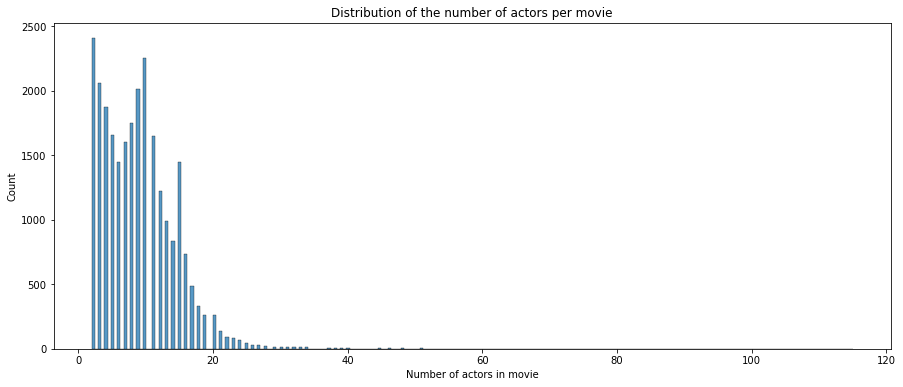

In average, there is 9.03 actors per movie among the american movies dataset with more than two actors.
There are 25938 unique movies which have a known list of actors greater than 2.


In [16]:
#nb actors per movie
plt.figure(figsize=(15, 6))
sns.histplot(data=df_movies, x='nb_actors')
plt.title("Distribution of the number of actors per movie")
plt.ylabel("Count")
plt.xlabel("Number of actors in movie")
plt.show()
avg_nb_actors_per_movie = df_movies['nb_actors'].mean()
nb_unique_movies_with_actors = df_movies['wikipedia_m_ID'].nunique()
print("In average, there is {:.2f} actors per movie among the american movies dataset with more than two actors.".format(avg_nb_actors_per_movie))
print("There are {} unique movies which have a known list of actors greater than 2.".format(nb_unique_movies_with_actors))

# 3.1 Number of movies of actor when releasing movie

In [17]:
#merge: if known score, column of score is = to score, otherwise = 0
df_chars_numbers = df_chars.merge(df_numbers, left_on='actor_name', right_index=True, how='left').copy()
df_chars_numbers.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,51.575733,46.667653,42.226639,38.208243,34.572248,31.282263,28.305362,25.611751,23.174471,20.969128
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,657.985608,860.979352,779.046334,1053.522550,1032.949430,934.651296,845.707465,765.227759,692.406710,626.515500
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,639.378954,651.576574,835.259518,755.774065,979.343060,1148.435483,1331.317686,1204.626058,1285.877630,1163.510195
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
map_nb_movies_per_year = df_chars_numbers.groupby(['m_release_date', 'actor_name'])['wikipedia_m_ID'].count().reset_index().copy()

In [56]:
nb_years = range(1980, 2013)
list_groups = dict()
for y in nb_years:
    list_year = map_nb_movies_per_year[map_nb_movies_per_year['m_release_date'].dt.year < y]
    list_groups.update({y: list_year.groupby('actor_name')['wikipedia_m_ID'].count()})

In [223]:
list_groups[2010]["'Crazy George' Henderson"]

1

In [65]:
def get_nb_movies_each_year(row):
    release_year = row['m_release_date'].year
    actor_name = row['actor_name']
    try:
        nb_movies = list_groups[release_year][actor_name]
    except:
        nb_movies = 0
    return nb_movies

In [66]:
df_chars_numbers['nb_movies_before_this_movie'] = df_chars_numbers.apply(lambda row: get_nb_movies_each_year(row), axis=1)

# 2.4 Compute scores per actor at movie time

In [71]:
df_chars_numbers = df_chars_numbers[df_chars_numbers['m_release_date'].dt.year > 1980].copy()

In [74]:
nb_unique_movies = df_chars_numbers['wikipedia_m_ID'].nunique()
print("There are {} unique movies with coacting.".format(nb_unique_movies))

There are 14572 movies with coacting.


In [75]:
def get_movie_actor_score(row):
    release_date = row['m_release_date'].year
    val = row[str(release_date-1)]
    if val > 0:
        return val
    else:
        return 0

In [76]:
df_chars_numbers['actor_score'] = df_chars_numbers.apply(lambda row: get_movie_actor_score(row), axis=1)

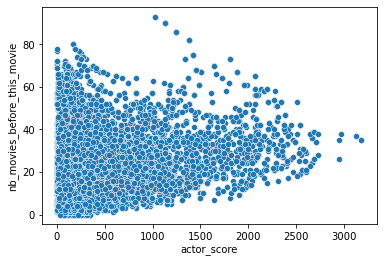

In [92]:
sns.scatterplot(data = df_chars_numbers[df_chars_numbers['actor_score']>0], y='nb_movies_before_this_movie', x='actor_score');

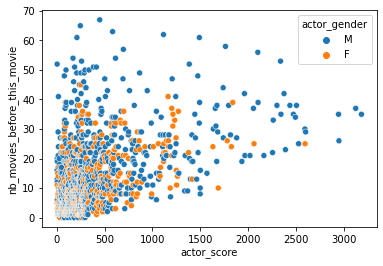

In [100]:
sns.scatterplot(data = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0)].sort_values('actor_score').drop_duplicates('actor_name', keep='last'), y='nb_movies_before_this_movie', x='actor_score', hue="actor_gender");

In [103]:
women_nb_movies_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='F')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['nb_movies_before_this_movie']
men_nb_movies_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='M')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['nb_movies_before_this_movie']

In [110]:
women_mean_nb_movies_highest_score = women_nb_movies_highest_score.mean()
men_mean_nb_movies_highest_score = men_nb_movies_highest_score.mean()
print("At the peak of their carreer, women had before performed {:.2f} movies in average.".format(women_mean_nb_movies_highest_score))
print("At the peak of their carreer, men had before performed {:.2f} movies in average.".format(men_mean_nb_movies_highest_score))
ttest_ind(women_nb_movies_highest_score, men_nb_movies_highest_score)

At the peak of their carreer, women had perform 11.23 movies in average.
At the peak of their carreer, men had perform 14.68 movies in average.


Ttest_indResult(statistic=-5.289603828102328, pvalue=1.4256491821257798e-07)

In [114]:
women_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='F')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['actor_score']
men_highest_score = df_chars_numbers.loc[(df_chars_numbers['actor_score']>0) & (df_chars_numbers['actor_gender']=='M')].sort_values('actor_score').drop_duplicates('actor_name', keep='last')['actor_score']

In [116]:
women_mean_highest_score = women_highest_score.mean()
men_mean_highest_score = men_highest_score.mean()
print("At the peak of their carreer, women have in average reached a score of {:.2f}.".format(women_mean_highest_score))
print("At the peak of their carreer, men have in average reached a score of {:.2f}.".format(men_mean_highest_score))
ttest_ind(women_highest_score, men_highest_score)

At the peak of their carreer, women have reached a score of 341.87.
At the peak of their carreer, men have reached a score of 420.87.


Ttest_indResult(statistic=-3.1909122073384775, pvalue=0.0014504355392797696)

# 2.5 Compute scores per movie

In [117]:
nb_unique_actors = df_chars_numbers['actor_name'].nunique()
print("There are {} unique actors with coacting.".format(nb_unique_actors))

There are 53669 unique actors with coacting.


In [119]:
df_chars_numbers.head(2)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2015,2016,2017,2018,2019,2020,2021,2022,nb_movies_before_this_movie,actor_score
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,0.000000
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.78,NaN,Natasha Henstridge,27.0,...,42.226639,38.208243,34.572248,31.282263,28.305362,25.611751,23.174471,20.969128,8,189.246665


In [124]:
columns = ['wikipedia_m_ID', 'actor_name', 'nb_movies_before_this_movie', 'actor_score']
df_temp = df_chars_numbers.copy()
df_temp['nb_movies_before_this_movie'] = df_temp['nb_movies_before_this_movie'].astype(str)
df_temp['actor_score'] = df_temp['actor_score'].astype(str)
df_grouped = df_temp[columns].groupby('wikipedia_m_ID').agg({'actor_name':'$l$'.join, 'nb_movies_before_this_movie':'$l$'.join, 'actor_score':'$l$'.join})

In [125]:
df_grouped

,actor_name,nb_movies_before_this_movie,actor_score
wikipedia_m_ID,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,7$l$0$l$10$l$8$l$0$l$2$l$0$l$2$l$0$l$1$l$3,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,5$l$21$l$1$l$2$l$2$l$9$l$3$l$7$l$7$l$6$l$6$l$1...,0.0$l$806.6699240571911$l$0.0$l$0.0$l$0.0$l$0....
3947,Dick Green$l$Isabella Rossellini$l$Kyle Maclac...,0$l$2$l$1$l$23$l$8$l$13$l$26$l$2$l$10$l$2$l$0$...,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
4231,Kristy Swanson$l$Donald Sutherland$l$Paul Reub...,7$l$30$l$10$l$13$l$1$l$1$l$0$l$1$l$0$l$2$l$0$l...,0.0$l$0.0$l$147.5916228316312$l$100.2165340214...
4560,Tommy Flanagan$l$Sean Lawlor$l$Sophie Marceau$...,1$l$0$l$0$l$7$l$14$l$3$l$5$l$0$l$0$l$0$l$1$l$0...,0.0$l$0.0$l$0.0$l$0.0$l$2014.0407164110889$l$0...
...,...,...,...
36619262,Leonardo Nam$l$Ryan O'Nan$l$Gillian Jacobs$l$J...,8$l$0$l$5$l$0$l$0$l$0$l$1$l$1$l$0$l$0$l$0,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
36724042,Krasimir Simeonov$l$John Barrowman$l$Jenny Mcs...,0$l$2$l$4$l$0$l$0$l$4$l$0$l$0$l$0,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...
36956792,Geraldine Brophy$l$Bruce Allpress$l$Edward Cam...,1$l$2$l$0$l$11$l$0$l$35$l$0$l$0$l$0$l$1$l$0$l$...,0.0$l$0.0$l$0.0$l$62.65663730093336$l$0.0$l$0....


In [133]:
def get_function_of_score(row, function):
    list_split = row['actor_score'].split('$l$')
    list_split = [float(x) for x in list_split]
    if function == 'max':
        return max(list_split)
    if function == 'min':
        return min(list_split)
    if function == 'mean':
        return np.mean(list_split)
    if function == 'median':
        return np.median(list_split)
    if function == 'nb_famous_actors':
        return np.count_nonzero(list_split)
    if function == 'weighted_mean':
        weights = [float(x) for x in row['nb_movies_before_this_movie'].split('$l$')]
        return np.multiply(weights,list_split).sum()
    if function == 'prop_famous_actors':
        return (np.count_nonzero(list_split))/float(len(list_split))

In [134]:
list_function_score = ['weighted_mean', 'max', 'min', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors']
for f in list_function_score:
    df_grouped[f] = df_grouped.apply(lambda row: get_function_of_score(row, f), axis=1)

In [135]:
df_grouped.head(2)

,actor_name,nb_movies_before_this_movie,actor_score,weighted_mean,max,min,mean,median,nb_famous_actors,prop_famous_actors
wikipedia_m_ID,,,,,,,,,,
3217,Ted Raimi$l$Ivan Raimi$l$Bruce Campbell$l$Brid...,7$l$0$l$10$l$8$l$0$l$2$l$0$l$2$l$0$l$1$l$3,0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$l$0.0$...,0.000000,0.000000,0.0,0.000000,0.0,0,0.000000
3746,William Sanderson$l$Harrison Ford$l$Rutger Hau...,5$l$21$l$1$l$2$l$2$l$9$l$3$l$7$l$7$l$6$l$6$l$1...,0.0$l$806.6699240571911$l$0.0$l$0.0$l$0.0$l$0....,16940.068405,806.669924,0.0,53.777995,0.0,1,0.066667


# 2.6 Merge score with actors

In [173]:
df_chars_merged = df_chars_numbers.merge(df_grouped[list_function_score], left_on='wikipedia_m_ID', right_index=True, how='left').copy()
df_chars_merged.head(3)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,2022,nb_movies_before_this_movie,actor_score,weighted_mean,max,min,mean,median,nb_famous_actors,prop_famous_actors
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,NaN,3,0.000000,18281.378519,810.280996,0.0,73.211437,0.0,5,0.294118
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,20.969128,8,189.246665,18281.378519,810.280996,0.0,73.211437,0.0,5,0.294118
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,626.515500,14,810.280996,18281.378519,810.280996,0.0,73.211437,0.0,5,0.294118


# 2.7 Min year and min year score of actors

In [137]:
def get_min_year(row):
    for x in df_numbers.columns[:-2]:
        if row[x] >0:
            return int(x)
    return 0

In [138]:
def get_min_year_score(row):
    for x in df_numbers.columns[:-2]:
        if row[x] >0:
            return float(row[x])
    return 0

In [174]:
#df_chars_numbers['min_year'] 
df_chars_merged['min_year'] = df_chars_merged.apply(lambda row: get_min_year(row), axis=1)
df_chars_merged['min_year_score'] = df_chars_merged.apply(lambda row: get_min_year_score(row), axis=1)
df_chars_merged.head(3)

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,actor_score,weighted_mean,max,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,0.000000,18281.378519,810.280996,0.0,73.211437,0.0,5,0.294118,0,0.000000
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,189.246665,18281.378519,810.280996,0.0,73.211437,0.0,5,0.294118,2000,189.246665
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,810.280996,18281.378519,810.280996,0.0,73.211437,0.0,5,0.294118,1991,258.969120


# 2.8 Number of actors revealed per movie

In [175]:
df_chars_merged['is_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] == row['m_release_date'].year, axis=1).astype(int)
df_chars_merged['already_revealed'] = df_chars_merged.apply(lambda row: row['min_year'] < row['m_release_date'].year and row['min_year']!=0.0, axis=1).astype(int)
df_chars_merged.head()

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,max,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score,is_revealed,already_revealed
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,...,810.280996,0.0,73.211437,0.0,5,0.294118,0,0.000000,0,0
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,NaN,Natasha Henstridge,27.0,...,810.280996,0.0,73.211437,0.0,5,0.294118,2000,189.246665,0,1
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,...,810.280996,0.0,73.211437,0.0,5,0.294118,1991,258.969120,0,1
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,...,810.280996,0.0,73.211437,0.0,5,0.294118,2000,63.082222,0,1
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea Duvall,23.0,...,810.280996,0.0,73.211437,0.0,5,0.294118,0,0.000000,0,0


# 3.1 Movies that have a revelation

In [176]:
df_movie_revelation = df_chars_merged.groupby('wikipedia_m_ID')['is_revealed'].sum().copy().reset_index()
df_movie_revelation.rename({'is_revealed' : 'has_revelation'}, axis=1, inplace=True)
df_movie_revelation['has_revelation'] = (df_movie_revelation['has_revelation'] > 0).astype(int)
df_movie_revelation.head()

,wikipedia_m_ID,has_revelation
0,3217,1
1,3746,1
2,3947,0
3,4231,0
4,4560,0


In [177]:
df_movie_revelation['has_revelation'].value_counts()

0    12791
1     1781
Name: has_revelation, dtype: int64

In [178]:
df_chars_revelation = df_chars_merged.merge(df_movie_revelation, on='wikipedia_m_ID', how='left').copy().sort_values(['wikipedia_m_ID', 'is_revealed'], ascending=False)

In [ ]:
df_chars_revelation

In [199]:
df_chars_revelation[df_chars_revelation['wikipedia_m_ID']==3217]

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score,is_revealed,already_revealed,has_revelation
81702,3217,/m/014hr,1992-10-09,Linda,1964-01-27,F,1.68,white Americans,Bridget Fonda,28.0,...,0.0,0.0,0.0,0,0.0,1992,338.651926,1,0,1
81699,3217,/m/014hr,1992-10-09,S-Mart Clerk,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,...,0.0,0.0,0.0,0,0.0,0,0.000000,0,0,1
81700,3217,/m/014hr,1992-10-09,Fake shemp,1956-01-01,M,NaN,NaN,Ivan Raimi,36.0,...,0.0,0.0,0.0,0,0.0,0,0.000000,0,0,1
81701,3217,/m/014hr,1992-10-09,Ash Williams,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,...,0.0,0.0,0.0,0,0.0,1993,3.320117,0,0,1
81703,3217,/m/014hr,1992-10-09,Sheila,1965-08-11,F,1.73,French Americans,Embeth Davidtz,27.0,...,0.0,0.0,0.0,0,0.0,1993,3.320117,0,0,1
81704,3217,/m/014hr,1992-10-09,Possessed Witch,1957-09-04,F,1.75,NaN,Patricia Tallman,35.0,...,0.0,0.0,0.0,0,0.0,0,0.000000,0,0,1
81705,3217,/m/014hr,1992-10-09,Duke Henry the Red,1955-01-01,M,NaN,NaN,Richard Grove,37.0,...,0.0,0.0,0.0,0,0.0,0,0.000000,0,0,1
81706,3217,/m/014hr,1992-10-09,Wiseman,1936-09-11,M,NaN,NaN,Ian Abercrombie,56.0,...,0.0,0.0,0.0,0,0.0,0,0.000000,0,0,1
81707,3217,/m/014hr,1992-10-09,Gold Tooth,NaN,NaN,NaN,NaN,Michael Earl Reid,NaN,...,0.0,0.0,0.0,0,0.0,0,0.000000,0,0,1
81708,3217,/m/014hr,1992-10-09,Blacksmith,NaN,M,NaN,NaN,Timothy Patrick Quill,NaN,...,0.0,0.0,0.0,0,0.0,0,0.000000,0,0,1


In [180]:
df_chars_revelation['is_revealed'].value_counts()

0    152538
1      2641
Name: is_revealed, dtype: int64

In [196]:
df_chars_revelation.loc[(df_chars_revelation.duplicated(subset=['wikipedia_m_ID'], keep=False))]

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score,is_revealed,already_revealed,has_revelation
148201,37501922,/m/0c0m5vt,1992-01-01,John Hunter,1966-10-11,M,1.765,NaN,Luke Perry,25.0,...,0.0,0.000000,0.0,0,0.000000,1994,99.603508,0,0,0
148202,37501922,/m/0c0m5vt,1992-01-01,Craig Murphy,1969-07-28,F,1.720,Jewish people,Alexis Arquette,22.0,...,0.0,0.000000,0.0,0,0.000000,0,0.000000,0,0,0
23371,37373877,/m/02vr316,2006-10-31,Beth Patterson,1970-02-04,F,1.600,British Indian people,Gabrielle Anwar,36.0,...,0.0,3.610508,0.0,2,0.285714,0,0.000000,0,0,0
23372,37373877,/m/02vr316,2006-10-31,NaN,1968-05-07,F,1.702,white Americans,Traci Lords,38.0,...,0.0,3.610508,0.0,2,0.285714,0,0.000000,0,0,0
23373,37373877,/m/02vr316,2006-10-31,Jennifer Jones,1968-12-22,F,1.700,NaN,Dina Meyer,37.0,...,0.0,3.610508,0.0,2,0.285714,1995,53.121871,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81705,3217,/m/014hr,1992-10-09,Duke Henry the Red,1955-01-01,M,NaN,NaN,Richard Grove,37.0,...,0.0,0.000000,0.0,0,0.000000,0,0.000000,0,0,1
81706,3217,/m/014hr,1992-10-09,Wiseman,1936-09-11,M,NaN,NaN,Ian Abercrombie,56.0,...,0.0,0.000000,0.0,0,0.000000,0,0.000000,0,0,1
81707,3217,/m/014hr,1992-10-09,Gold Tooth,NaN,NaN,NaN,NaN,Michael Earl Reid,NaN,...,0.0,0.000000,0.0,0,0.000000,0,0.000000,0,0,1
81708,3217,/m/014hr,1992-10-09,Blacksmith,NaN,M,NaN,NaN,Timothy Patrick Quill,NaN,...,0.0,0.000000,0.0,0,0.000000,0,0.000000,0,0,1


In [193]:
df_chars_revelation.loc[(df_chars_revelation.duplicated(subset=['wikipedia_m_ID'], keep=False)) & (df_chars_revelation.duplicated(subset=['wikipedia_m_ID', 'has_revelation'], keep=False)) & df_chars_revelation['is_revealed']==1].sort_values('wikipedia_m_ID')

,wikipedia_m_ID,freebase_m_ID,m_release_date,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,...,min,mean,median,nb_famous_actors,prop_famous_actors,min_year,min_year_score,is_revealed,already_revealed,has_revelation
81702,3217,/m/014hr,1992-10-09,Linda,1964-01-27,F,1.680,white Americans,Bridget Fonda,28.0,...,0.0,0.000000,0.000000,0,0.000000,1992,338.651926,1,0,1
45404,3746,/m/017n9,1982-06-25,Rachael,1959-11-20,F,1.753,NaN,Sean Young,22.0,...,0.0,53.777995,0.000000,1,0.066667,1982,262.289237,1,0,1
62549,5313,/m/01mgw,2000-05-16,Jen Yu,1979-02-09,F,1.630,NaN,Zhang Ziyi,21.0,...,0.0,25.797979,0.000000,2,0.125000,2000,295.490406,1,0,1
56767,9835,/m/02p5d,1981-05-23,Snake Plissken,1951-03-17,M,1.780,NaN,Kurt Russell,30.0,...,0.0,19.367349,0.000000,1,0.083333,1981,235.728302,1,0,1
72769,13149,/m/03fts,1999-12-23,Sir Alexander Dane,1946-02-21,M,1.854,British people,Alan Rickman,53.0,...,0.0,84.516026,0.000000,2,0.105263,1999,235.728302,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90268,34888850,/m/0h1jny6,2012-01-01,NaN,1989-10-14,F,1.620,NaN,Mia Wasikowska,22.0,...,0.0,298.441729,278.824566,5,0.833333,2012,63.082222,1,0,1
72726,34953010,/m/0j43swk,2012-12-19,NaN,1974-06-23,M,1.803,NaN,Joel Edgerton,38.0,...,0.0,94.747388,0.000000,5,0.416667,2012,126.164443,1,0,1
72725,34953010,/m/0j43swk,2012-12-19,NaN,1969-07-17,M,NaN,Australians,Jason Clarke,43.0,...,0.0,94.747388,0.000000,5,0.416667,2012,63.082222,1,0,1
130300,35589999,/m/0gxmvbv,2012-09-01,Lincoln,1976-08-25,M,1.940,Swedes,Alexander Skarsgård,NaN,...,0.0,263.794951,243.085404,2,0.666667,2012,179.286314,1,0,1


In [191]:
df_chars_revelation.drop_duplicates(subset=['wikipedia_m_ID', 'has_revelation'], keep='first')['is_revealed'].value_counts()

0    12791
1     1781
Name: is_revealed, dtype: int64

In [ ]:
df_one_known_unique = df_chars_merged[df_chars_merged['nb_famous_actors'] > 0].drop_duplicates(subset=['wikipedia_m_ID', 'is_revealed'], keep='first').copy()
df_one_known_unique = df_one_known_unique.sort_values(['wikipedia_m_ID', 'is_revealed'])
df_one_known_unique = df_one_known_unique.drop_duplicates(subset=['wikipedia_m_ID'], keep='last').copy()

In [ ]:
df_one_known_unique['is_revealed'].value_counts()

In [ ]:
df_one_known_unique.groupby('is_revealed').mean()

In [ ]:
columns = ['wikipedia_m_ID', 'actor_name', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors', 'is_revealed']
dataset = df_one_known_unique[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean()

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [ ]:
X = dataset.drop('is_revealed', axis=1)
y = dataset['is_revealed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(max_iter=10000, C=0.5, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

In [ ]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

In [ ]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, y_pred)
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix")
plt.show()

In [ ]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

In [ ]:
df_movies_reveal = df_chars_merged.groupby('wikipedia_m_ID')['is_revealed'].sum().reset_index().sort_values('is_revealed')
prop_movies_with_reveal = df_movies_reveal['is_revealed'].sum()/df_movies_reveal['is_revealed'].count()
print("There are {:.2f}% of movies where at least one actor was revealed.".format(prop_movies_with_reveal*100))

df_movies_reveal_only = df_movies_reveal[df_movies_reveal['is_revealed'] > 0]

plt.figure(figsize=(12, 5))
sns.histplot(data=df_movies_reveal_only, x = 'is_revealed')
plt.title("Distribution of the number of actors revealed per movie")
plt.ylabel("Count")
plt.xlabel("Number of actors revealed")
plt.show()

In [ ]:
df_movies_reveal.rename({'is_revealed':'nb_revealed'}, axis=1, inplace=True)

In [ ]:
df_chars_merged = df_chars_merged.merge(df_movies_reveal, left_on='wikipedia_m_ID', right_on='wikipedia_m_ID', how='left').copy()

# 3.1 Correlation

In [ ]:
df_chars_merged['is_revealed'].value_counts()

In [ ]:
df_all_binary = df_chars_merged.drop_duplicates(subset=['wikipedia_m_ID', 'is_revealed'], keep='first')

In [ ]:
columns = ['wikipedia_m_ID', 'actor_name', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors', 'is_revealed']
dataset = df_all_binary[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean()

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [ ]:
df_all_binary['is_revealed'].value_counts()

In [ ]:
df_all_binary.groupby('is_revealed').mean()

# 3.2 Training

In [ ]:
X = dataset.drop('is_revealed', axis=1)
y = dataset['is_revealed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(solver='liblinear', max_iter=10000, C=2, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

In [ ]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

In [ ]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

In [ ]:
# Weight of each column in logistic regression
tmp = []
for name, value in zip(dataset.columns, clf.coef_[0]):
    tmp.append({"name": name, "value": value})

features_coef = pd.DataFrame(tmp).sort_values("value")

plt.subplots(figsize=(5,7))
plt.barh(features_coef.name, features_coef.value, alpha=0.6)
plt.show()

# 4.1 Only unknown actors

In [ ]:
df_unknown = df_chars_merged[df_chars_merged['nb_famous_actors'] == 0]

In [ ]:
df_chars_merged['is_revealed'].value_counts()

In [ ]:
df_unknown['is_revealed'].value_counts()

# 5.1 Movies with at least one famous actor

In [ ]:
df_one_known = df_chars_merged[df_chars_merged['nb_famous_actors'] > 0].drop_duplicates(subset=['wikipedia_m_ID', 'is_revealed'], keep='first')

In [ ]:
plt.figure(figsize=(15, 6))
sns.histplot(data=df_one_known, x='nb_famous_actors', hue='is_revealed', stat = 'density', common_norm=False, shrink = 1.5, multiple="dodge")
plt.show()

In [ ]:
ttest_ind(df_one_known[df_one_known['is_revealed'] == 0]['nb_famous_actors'], df_one_known[df_one_known['is_revealed'] == 1]['nb_famous_actors'])

In [ ]:
df_one_known.groupby('is_revealed').mean()

In [ ]:
columns = ['wikipedia_m_ID', 'actor_name', 'mean', 'median', 'nb_famous_actors', 'prop_famous_actors', 'is_revealed']
dataset = df_one_known[columns].groupby(['wikipedia_m_ID', 'actor_name']).mean()

# Heatmap of the correlation between the attributes
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype='bool'))

plt.figure(figsize=(15, 8))
cmap = sns.diverging_palette(240,240, as_cmap=True)
sns.heatmap(data=corr, cmap=cmap, center=0, mask=mask, annot=True)
plt.show()

In [ ]:
X = dataset.drop('is_revealed', axis=1)
y = dataset['is_revealed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(max_iter=100000, C=0.2, class_weight='balanced')
clf.fit(X_train, y_train)

# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

In [ ]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

In [ ]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

# 6.1 Movies with at least one famous actor and no same movie

In [ ]:
filter_conditions = (
    (df_final["min_year"] != 1980) &
    (df_final["min_year"] <= df_final["m_release_date"].dt.year)
)

df_final = df_final.loc[
    filter_conditions,
].copy(deep=True)

In [ ]:
df_final = df_final[df_final.duplicated('wikipedia_m_ID', keep=False)].copy()

In [ ]:
df_final[df_final.duplicated(['actor_name'], keep=False)].copy()

In [ ]:
df_final[df_final['already_revealed'] == 0]

In [ ]:
columns = ['wikipedia_m_ID', 'm_release_date', 'movie_score_sum', 'movie_score_min', 'movie_score_max', 'movie_score_mean', 'movie_score_weighted_mean', 'is_revealed']
df_final[columns].groupby(['wikipedia_m_ID'])['is_revealed'].sum().value_counts().plot(kind='bar')

In [ ]:
columns = ['wikipedia_m_ID', 'm_release_date', 'movie_score_sum', 'movie_score_min', 'movie_score_max', 'movie_score_mean', 'movie_score_weighted_mean', 'already_revealed']
plt.figure(figsize=(15, 6))
new_df_plot = df_final[columns].groupby(['wikipedia_m_ID'])['already_revealed'].sum().value_counts().reset_index().sort_values('index')
sns.barplot(data=new_df_plot, x='index', y='already_revealed')

In [ ]:
columns = ['wikipedia_m_ID', 'actor_name', 'm_release_date', 'movie_score_sum', 'movie_score_min', 'movie_score_max', 'movie_score_mean', 'movie_score_weighted_mean', 'is_revealed', 'already_revealed', 'nb_actors']
df_grouped = (df_final[columns].groupby(['wikipedia_m_ID', 'actor_name']).sum()).copy()

In [ ]:
nb_movies_already_revealed = df_grouped.groupby('wikipedia_m_ID')['already_revealed'].sum()

In [ ]:
df_grouped.reset_index(inplace=True)

In [ ]:
df_grouped['nb_already_revealed'] = df_grouped['wikipedia_m_ID'].apply(lambda x: nb_movies_already_revealed[x])
df_grouped['pro_actors_already_revealed'] = df_grouped.apply(lambda row: row['nb_already_revealed'] / row['nb_actors'], axis=1)

In [ ]:
df_grouped.groupby('is_revealed').mean()

# 2.3 Training

In [ ]:
df_grouped.set_index(['wikipedia_m_ID', 'actor_name'], inplace=True)

In [ ]:
df_test = df_grouped
df_test = df_grouped.drop_duplicates(keep='first')

In [ ]:
df_test['pro_actors_already_revealed'].hist(bins=50)

In [ ]:
df_test.groupby('is_revealed').mean()

In [ ]:
X = df_test.drop(['is_revealed', 'already_revealed', 'nb_actors', 'nb_already_revealed', 'pro_actors_already_revealed'], axis=1).values
y = df_test['is_revealed']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Dictionary to store the results
logistic_regression_results = dict()

# Build and fit classifier to training data
clf = LogisticRegression(solver='liblinear', max_iter=10000, C=2, class_weight='balanced')
clf.fit(X_train, y_train)

In [ ]:
# Training set accuracy
y_pred = clf.predict(X_train)
acc_tr = accuracy_score(y_pred, y_train) * 100
print("Accuracy on the training data: {:.2f}%".format(acc_tr))

In [ ]:
# Predict the binary output with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict")
# Compute the False Positive Rate and True Positive Rate
print(classification_report(y_pred, y_test))

In [ ]:
# Creation of confusion matrix
cm = confusion_matrix(y_test, (y_pred[:,1]>=0.3).astype(int))
conf_matrix=pd.DataFrame(data=cm, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1'])
logistic_regression_results.update({'cm': conf_matrix})

# Plot confusion matrix
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap = 'Reds')
plt.title("Confusion matrix if threshold = 0.5")
plt.show()

In [ ]:
# Predict the probabilities with a cross validationn
y_pred = cross_val_predict(clf, X_test, y_test, cv=10, method="predict_proba")

#Compute the precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred[:, 1])

#Compute the false positive rate and true positive rate
fpr, tpr, _ = roc_curve(y_test, y_pred[:, 1])

# Compute the area under the P-R curve and ROC curve
pr_score = auc(recall, precision)
roc_score = auc(fpr, tpr)

logistic_regression_results.update({'precision': precision})
logistic_regression_results.update({'recall': recall})
logistic_regression_results.update({'pr_score': pr_score})
logistic_regression_results.update({'fpr': fpr})
logistic_regression_results.update({'tpr': tpr})
logistic_regression_results.update({'roc_score': roc_score})

In [ ]:
# Plot P-R curve and ROC curve
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

ax = axs[0]
ax.plot(recall, precision, label='logistic')
ax.plot([1, 0], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision-Recall Curve - Area = {:.3f}".format(pr_score))
ax.legend(loc = 'lower left')

ax = axs[1]
ax.plot(fpr, tpr, label='logistic')
ax.plot([0, 1], [0, 1],'r--', label = 'no skill')
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("ROC Curve - Area = {:.3f}".format(roc_score))
ax.legend(loc = 'lower right')

fig.suptitle('Logistic regression')
fig.tight_layout()
plt.show()

# 3.1 One hot

In [ ]:
df_chars_numbers = df_chars.merge(df_numbers, left_on='actor_name', right_index=True)
df_chars_numbers.head()

In [ ]:
#checkez les 600 restant·e·s
df_chars_numbers['actor_name'].nunique()

In [ ]:
df_chars_numbers['wikipedia_m_ID'].count()

In [ ]:
df_chars_numbers.drop_duplicates(subset=['wikipedia_m_ID', 'actor_name'], keep='first', inplace=True)

In [ ]:
df_chars_numbers.head()

In [ ]:
def get_min_year_score(row):
    for x in df_numbers.columns[:-2]:
        if row[x] >0:
            return float(row[x])

In [ ]:
def get_min_year(row):
    for x in df_numbers.columns[:-2]:
        if row[x] >0:
            return int(x)

In [ ]:
#df_chars_numbers['min_year'] 
df_chars_numbers['min_year'] = df_chars_numbers.apply(lambda row: get_min_year(row), axis=1)
df_chars_numbers['min_year_score'] = df_chars_numbers.apply(lambda row: get_min_year_score(row), axis=1)

In [ ]:
df_chars_numbers.head()

In [ ]:
df_chars_numbers.head(10)

In [ ]:
df_chars_test = df_chars_numbers.copy()
df_chars_test.head()

In [ ]:
# 1.7 (second way of doing it)
df_final = df_chars_test.merge(df_chars_test, on=['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date'], how='left')

In [ ]:
df_final.head()

In [ ]:
filter_conditions = (
    (df_final["actor_name_x"] != df_final["actor_name_y"]) &
    (df_final["min_year_x"] > 1980) &
    (df_final["min_year_x"] > df_final["min_year_y"]) &
    (df_final["min_year_x"] == df_final["m_release_date"].dt.year)
)

df_final = df_final.loc[
    filter_conditions,
].copy(deep=True)

In [ ]:
df_final[df_final['actor_name_x'] == 'Zac Efron'][['wikipedia_m_ID', 'freebase_m_ID', 'm_release_date', 'character_name_x','actor_dob_x', 'actor_gender_x', 'actor_height_x', 'actor_ethnicity_x','actor_name_x', 'actor_age_x','actor_name_y', 'min_year_x', 'min_year_y']]
#df_final[df_final['actor_name_x'] == 'Natasha Henstridge']

In [ ]:
df_final['actor_name_y'].value_counts()

In [ ]:
#df_final['diff_year'] = df_final.apply(lambda row: row['m_release_date'].year - row['min_year_x'], axis=1)

In [ ]:
df_final

In [ ]:
columns = ['wikipedia_m_ID', 'm_release_date','actor_dob_x', 'actor_gender_x', 'actor_height_x',
           'actor_name_x', 'actor_age_x', 'mean_score_x','min_year_x', 'actor_dob_y', 'actor_gender_y', 'actor_height_y',
          'actor_name_y', 'actor_age_y','1980_y', '1981_y', '1982_y', '1983_y', '1984_y', '1985_y', '1986_y', '1987_y',
       '1988_y', '1989_y', '1990_y', '1991_y', '1992_y', '1993_y', '1994_y', '1995_y', '1996_y', '1997_y',
       '1998_y', '1999_y', '2000_y', '2001_y', '2002_y', '2003_y', '2004_y', '2005_y', '2006_y', '2007_y',
       '2008_y', '2009_y', '2010_y', '2011_y', '2012_y', '2013_y', '2014_y',
       '2015_y', '2016_y', '2017_y', '2018_y', '2019_y', '2020_y', '2021_y', '2022_y', 'mean_score_y','min_year_y']

In [ ]:
df_test = pd.get_dummies(df_final, columns=['actor_name_y'], prefix='').copy()
df_test.head()

In [ ]:
df_final[df_final['actor_name_x']=='Harry J. Lennix'][['actor_name_x', 'actor_name_y', 'm_release_date', 'min_year_x', 'min_year_y']]

In [ ]:
columns = [col for col in df_test if col.startswith('_')]

In [ ]:
def change_actor_one_hot_weight(row, actor):
    if row[actor] != 1:
        return row[actor]
    else:
        release_date = row['m_release_date'].year
        weight = 0
        career = range(row['min_year_y'], release_date)
        for x in career:
            if row[str(x)+'_y']:
                weight+=row[str(x)+'_y']
        weight = weight/len(career)
        return weight

In [ ]:
import time
for actor in columns:
    df_test[actor] = df_test.apply(lambda row: change_actor_one_hot_weight(row, actor), axis=1)

In [ ]:
df_test

In [ ]:
columns.append('actor_name_x')
X = df_test[columns].groupby('actor_name_x').sum().copy().values

In [ ]:
X.sum(axis=0)

In [ ]:
X.sum(axis=0).std()

In [ ]:
y = df_test.drop_duplicates('actor_name_x', keep='first')['min_year_score_x']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_train, y_train)
reg.score(X_test, y_test)

In [ ]:
#reg.predict(X_test)